## Objective

### Investigate insights as to why there were orders that were not completed successfully. (I.e. The customer didn't end up getting a car)

#### This notebook will explore:

1. Distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?
2. Distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?
3. What is the average time to cancel on average? Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?
4. Distribution of average ETA by hours. How can this plot be explained?

### Next Steps

+ Read in datasets and begin exploring

In [1]:
# reading in the libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import statistics

# reading in offers csv
offers = pd.read_csv('data/data_offers.csv')

# reading in orders.csv
orders = pd.read_csv('data/data_orders.csv')

### First Steps

+ Load in offers and orders dataset
+ Look at the first five rows 

In [2]:
# looking at the first five rows of the offers dataset
offers.head(5)

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [3]:
# understanding the data landscape of the offers dataset
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


In [4]:
# looking at the first five columns of the orders dataset
orders.head(5)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [5]:
# understanding the data landscape of the orders dataset
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


### Next Steps

+ Manipulation of data will be more efficient if the tables are merged
+ Merge the tables on the order number
+ Merging tables is the python version of joining tables in SQL
+ Defining the how to merge the table (outer, left, right, inner) and on a specific row or rows is the purpose

In [6]:
# merging the tables and rename column order_datetime to order_date
df = pd.merge(orders, offers, how = 'inner', on = 'order_gk').rename({"order_datetime" : "order_time"}, axis = 1)
df

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275
...,...,...,...,...,...,...,...,...,...
31263,12:44:11,-0.975372,51.457846,NaN,3000597886155,4,0,43.0,300051590196
31264,12:42:52,-0.975372,51.457846,NaN,3000597886140,4,0,44.0,300051590176
31265,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0,300051648809
31266,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0,300051648910


In [7]:
# taking a random sample from the dataset and looking at ten examples
df.sample(n = 10, random_state = 42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,4,1,223.0,300050725946
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,4,0,91.0,300052014519
29083,9:16:38,-1.033560,51.441967,NaN,3000594099225,4,0,68.0,300051458740
16926,2:08:09,-0.967676,51.444489,NaN,3000626980467,4,0,125.0,300052031394
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,4,0,11.0,300050671163
13008,3:03:45,-0.966745,51.453236,NaN,3000593295623,9,0,NaN,300051413313
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,4,0,6.0,300051090742
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,9,0,NaN,300051125957
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,4,0,113.0,300052078801
18189,7:52:29,-0.973793,51.458665,479.0,3000587781360,4,1,47.0,300051178628


### Observation

+ After merging and looking at the data, two columns stuck out and believe we can feature engineer them to be more readable
+ They are:
+ is_driver_assigned_key - whether a driver has been assigned. Instead of 1 and 0 for Yes and No, Yes and No would help read the data easier
+ order_status_key - status, an enumeration consisting of the following mapping:
- 4 - cancelled by client,
- 9 - cancelled by system, i.e., a reject

+ Instead of 4 and 9, we can feature engineer it to read Client Cancellation instead of 4, and System Cancellation instead if 9

### Next Steps

+ This can be performed using the numpy where function
+ It essentially works like an =IF() statement in google sheets where if the condition is true, you can give it a specific label or else name the label something different
+ Ie. If order_status_key equals 4, label it Client Cancellation, or else name it System Cancellation
+ In SQL, this is similar to the CASE WHEN function 
+ Ie. CASE WHEN order_status_key = 4 THEN 'Client Cancellation' ELSE 'System Cancellation' END 

In [8]:
# using the numpy where function on the is_driver_assigned_key, renaming the column and replacing 1, 0 with Yes or No to make improve data readibility
df['is_driver_assigned'] = np.where(df['is_driver_assigned_key'] == 1, "Yes", "No")

# using the numpy where function on the order_status_key, renaming the column and replacing 4, 9 with Client Cancellation or System Cancellation to make improve data readibility
df['order_status'] = np.where(df['order_status_key'] == 4, "Client Cancellation", "System Cancellation")

# taking a random sample from the dataset and looking at ten examples
df.sample(n = 10, random_state = 42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,4,1,223.0,300050725946,Yes,Client Cancellation
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,4,0,91.0,300052014519,No,Client Cancellation
29083,9:16:38,-1.033560,51.441967,NaN,3000594099225,4,0,68.0,300051458740,No,Client Cancellation
16926,2:08:09,-0.967676,51.444489,NaN,3000626980467,4,0,125.0,300052031394,No,Client Cancellation
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,4,0,11.0,300050671163,No,Client Cancellation
13008,3:03:45,-0.966745,51.453236,NaN,3000593295623,9,0,NaN,300051413313,No,System Cancellation
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,4,0,6.0,300051090742,No,Client Cancellation
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,9,0,NaN,300051125957,No,System Cancellation
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,4,0,113.0,300052078801,No,Client Cancellation
18189,7:52:29,-0.973793,51.458665,479.0,3000587781360,4,1,47.0,300051178628,Yes,Client Cancellation


### Distribution of orders according to reasons for failure

+ Cancellations before and after driver assignment, and reasons for order rejection 
+ Analyze the resulting plot. Which category has the highest number of orders?

### Next Steps

+ Understand the distribution of order cancellations by driver assigned and order_status
+ Create a new table grouped by is_driver_assigned and order_status, with a count to understand the distribution

In [9]:
# creating a table called cancellations grouped by is_driver_assigned and order_status and renaming columns order_gk to orders cancelled
cancellations= df.groupby(['is_driver_assigned', 'order_status'])['order_gk'].count().reset_index().rename({"order_gk" : "orders_cancelled"}, axis = 1)

# adding a new column called perc_of_cancelled represnting the overall percentage of cancellations each row contributes to the total
cancellations['perc_of_cancelled'] = round(cancellations['orders_cancelled'] / cancellations['orders_cancelled'].sum() * 100, 2)

cancellations

,is_driver_assigned,order_status,orders_cancelled,perc_of_cancelled
0,No,Client Cancellation,13435,42.97
1,No,System Cancellation,9469,30.28
2,Yes,Client Cancellation,8360,26.74
3,Yes,System Cancellation,4,0.01


### Creating a visual for the table above

+ Let's create a visual for the table and information above
+ It should be clear in telling the story above which is:
+ Close to 75% or orders are being cancelled prior to the driver being assigned to a Customer
+ Customers cancelling the order prior to the driver being assigned is the leading contributor
+ That being said, system cancellations make up just over 30% of cancellations prior to the driver being assigned

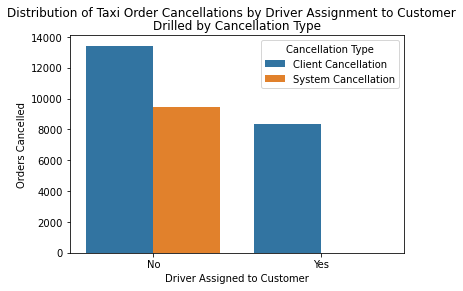

In [10]:
# building the barplot and passing the necessary variables through
sns.barplot(data = cancellations, x = 'is_driver_assigned', y = 'orders_cancelled', hue = 'order_status')

# passing the superior title, because there is a drill down to cancellation type, adding a subtitle 
plt.suptitle("Distribution of Taxi Order Cancellations by Driver Assignment to Customer")

# creating the subtitle
plt.title("Drilled by Cancellation Type")

# switching the legend title from order_status to Cancellation Type
plt.legend(title = "Cancellation Type")

# renaming the x axis Driver Assigned to Customer 
plt.xlabel("Driver Assigned to Customer")

# renaming the y axis Orders Cancelled
plt.ylabel("Orders Cancelled")
plt.show();

### Observations

+ 73% of Cancellations occur before a driver is assigned
+ After the driver is assigned, however, it is almost always the customer cancelling the order
+ There were 4 orders rejected by the system, which may be worth exploring how often this happens and the cost associated with it
+ It should be flagged to Product and Engineering to be on their radar, and if the cost is high, it may become a higher priority

### Some Questions...

+ The data above has been helpful in understand where the root of the cancellations begin
+ But a few questions comes to mind..

### Such As

+ When are most of these cancellations happening from an hour perspective?
+ What are the drivers behind so many customers cancelling their orders before a driver is assigned? - It would be helpful to know the average time to assign a driver for baseline
+ Could the Customer wait time for a driver being assigned to their order be a leading cause of cancellations?
+ How long are Customers approximately waiting to cancel their order prior to a driver being assigned?
+ Having more information on driver assignment such as: average time to accept an order is an important piece of information I would request to have and ask for any other important data points

## To answer that 

+ Build a table called cancellations by hour to under the distribution of cancellations by hour
+ Build a separate table called is_driver_assigned_hour
+ Have the total count of orders, as well as the average cancellation time in seconds grouped by hour and driver assigned

### Next Steps

+ Create a new column containing the hour to manipulate data
+ We do this by usind the dt.hour function with the datetime library
+ Create a table by hour and the number of cancellation to get a better illustration of the distribution

In [11]:
# creating a new column with the hour from the order time
df['hour'] = pd.to_datetime(df['order_time']).dt.hour

In [12]:
# taking a random sample from the dataset and looking at ten examples
df.sample(n = 10, random_state = 42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status,hour
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,4,1,223.0,300050725946,Yes,Client Cancellation,21
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,4,0,91.0,300052014519,No,Client Cancellation,10
29083,9:16:38,-1.033560,51.441967,NaN,3000594099225,4,0,68.0,300051458740,No,Client Cancellation,9
16926,2:08:09,-0.967676,51.444489,NaN,3000626980467,4,0,125.0,300052031394,No,Client Cancellation,2
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,4,0,11.0,300050671163,No,Client Cancellation,21
13008,3:03:45,-0.966745,51.453236,NaN,3000593295623,9,0,NaN,300051413313,No,System Cancellation,3
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,4,0,6.0,300051090742,No,Client Cancellation,14
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,9,0,NaN,300051125957,No,System Cancellation,20
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,4,0,113.0,300052078801,No,Client Cancellation,18
18189,7:52:29,-0.973793,51.458665,479.0,3000587781360,4,1,47.0,300051178628,Yes,Client Cancellation,7


In [13]:
# creating a new table that has order cancellations by hour 
cancellations_by_hour = df.groupby('hour')['order_gk'].count().reset_index().rename({"order_gk" : "cancellation count"}, axis = 1)

# creating a new column to measure percentage of cancellations by hour from the total
cancellations_by_hour['perc_of_cancellations'] = round(cancellations_by_hour['cancellation count'] / cancellations_by_hour['cancellation count'].sum() * 100 , 2)

# looking at the entire dataframe to ensure the data looks good
cancellations_by_hour

,hour,cancellation count,perc_of_cancellations
0,0,1993,6.37
1,1,1305,4.17
2,2,1475,4.72
3,3,1418,4.53
4,4,227,0.73
5,5,111,0.35
6,6,392,1.25
7,7,1566,5.01
8,8,3865,12.36
9,9,1258,4.02


### Creating a line graph visual of the order cancellations by hour

+ Looking at the data above, the line graph will have a big speak in the middle of morning hours given the fact 8 am has the biggest number of cancellations
+ Cancellations begin to rise in the afternoon so there will be peaks towards 3 pm or 15:00, as well as 17:00 
+ There is a slight drop for about an hour, and towards nighttime and early morning hours the volume of cancellations rises

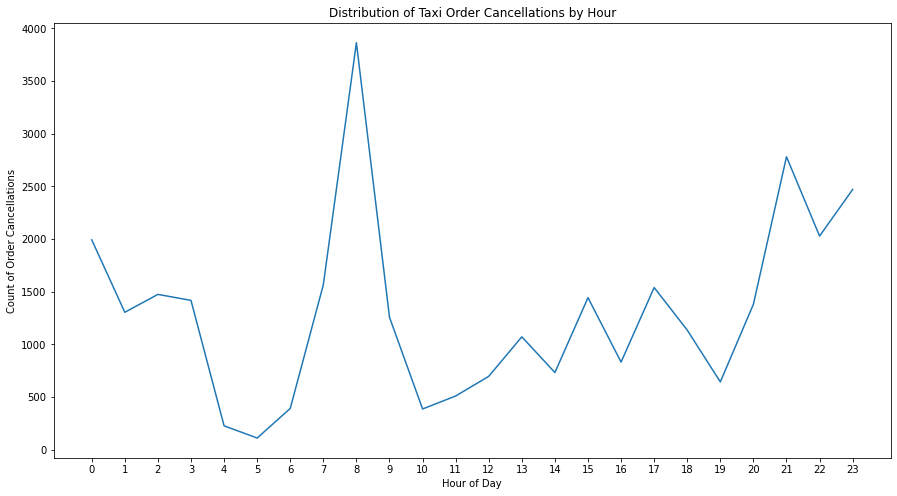

In [14]:
fig, ax = plt.subplots(figsize = (15, 8))

# creating the line graph and passing cancellations as the data source
sns.lineplot(data = cancellations_by_hour, x = 'hour', y = 'cancellation count', ax = ax)

# adding a title to called Distribution of Cancellations by Hour
plt.title('Distribution of Taxi Order Cancellations by Hour')

# renaming x axis to Hour of Day for clarity
plt.xlabel('Hour of Day')

# reseeting the x axis to show all hours not grouped
plt.xticks(ticks = cancellations_by_hour['hour'])

# renaming the y axis to Count of Order Cancellations
plt.ylabel('Count of Order Cancellations')

plt.show();

### Observations from the visual above

+ Looking at the line graph above, it tells the story of cancellations in an easier to digest format
+ Higher peaks in the early hours in the morning, followed by a big drop and then followed by the big 8 AM cancellation peak
+ Cancellations stay somehat consistent for the afternoon with peaks cancellations around 15:00 and 17:00 and around 20:00PM the peaks begin to rise again

### Next Steps 

+ Create a table getting the cancellation count and average cancellation time grouped by the hour and is_driver_assigned
+ We will need to calculate the average cancellation unassigned and assigned orders to understand if wait times could be a main contributor to the cancellations

### Distribution of Hours Complete, moving on to

+ Create is_driver_assigned_hour table
+ Table is group by hour, and is driver assigned, counting the number of cancelled orders and also measuring cancellations in seconds

### Goal

+ What are the drivers behind so many customers cancelling their orders before a driver is assigned?
+ Could the Customer wait time for a driver being assigned to their order be a leading cause?
+ How long are Customers approximately waiting to cancel their order prior to a driver being assigned?

In [15]:
# creating a new table getting the cancellation count and average cancellation time grouped by the hour and is_driver_assigned
is_driver_assigned_hour = df.groupby(['hour', 'is_driver_assigned']).agg({"order_gk" : "count", "cancellations_time_in_seconds" : "mean"}).reset_index().rename({"order_gk" : "cancellation count"}, axis = 1)

# rounding the cancellations time in seconds to nearest 2 decimal points
is_driver_assigned_hour['cancellations_time_in_seconds'] = round(is_driver_assigned_hour['cancellations_time_in_seconds'], 2)

# getting the average cancellation time by assigned orders (meaning a driver was assigned)
assigned_avg = round(is_driver_assigned_hour[is_driver_assigned_hour['is_driver_assigned'] == 'Yes']['cancellations_time_in_seconds'].mean(),2)

# getting the average cancellation time by assigned orders (meaning a driver was assigned)
unassigned_avg = round(is_driver_assigned_hour[is_driver_assigned_hour['is_driver_assigned'] == 'No']['cancellations_time_in_seconds'].mean(),2)

# looking at the entire dataset to
is_driver_assigned_hour

,hour,is_driver_assigned,cancellation count,cancellations_time_in_seconds
0,0,No,1663,115.13
1,0,Yes,330,276.08
2,1,No,1007,100.59
3,1,Yes,298,296.31
4,2,No,1235,121.31
5,2,Yes,240,301.47
6,3,No,1223,129.18
7,3,Yes,195,368.68
8,4,No,135,100.73
9,4,Yes,92,245.25


In [16]:
# printing out averages for reference
print(f"The average cancellation time for unassigned orders is {unassigned_avg} seconds, while the average cancellation time for assigned orders is {assigned_avg} seconds.")

The average cancellation time for unassigned orders is 118.56 seconds, while the average cancellation time for assigned orders is 240.19 seconds.


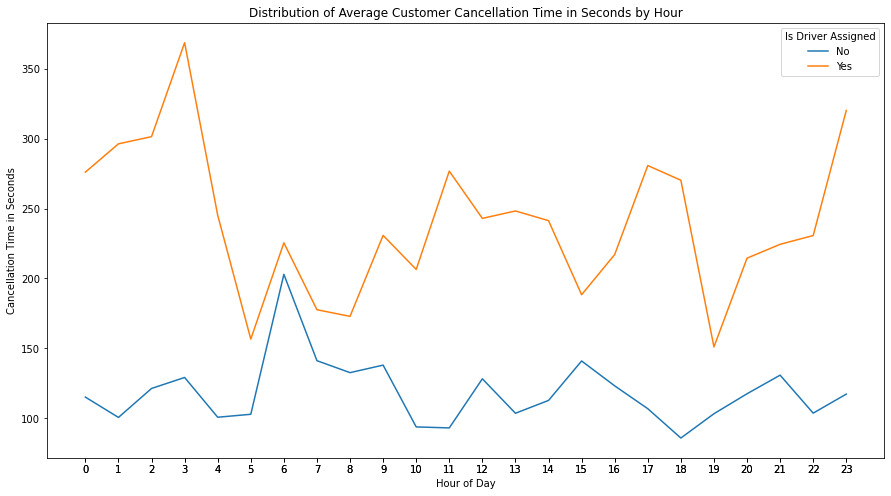

In [17]:
# creating a new figure with a size of 15 x 8 
fig, ax = plt.subplots(figsize = (15,8))

# creating a lineplot using seaborn and passing is_driver_assigned_hour as the data source
sns.lineplot(data = is_driver_assigned_hour, x = 'hour', y = 'cancellations_time_in_seconds', hue = 'is_driver_assigned', ax = ax)

# renaming the title of the chart 
plt.title('Distribution of Average Customer Cancellation Time in Seconds by Hour')

# renaming the legend title to Is Driver Assigned, and assigning it to the best recommended location
plt.legend(title = 'Is Driver Assigned', loc = 'best')

# renaming x axis to Hour of Day
plt.xlabel('Hour of Day')

# setting the tick marks to display all hours
plt.xticks(ticks = is_driver_assigned_hour['hour'])

# renaming the y axis to Cancellations Time in Seconds
plt.ylabel('Cancellation Time in Seconds')

# displaying the plot
plt.show();

### Observations

+ Orders with drivers assigned have a higher average cancellation time without exception
+ Most of the unassigned cancellations are less than or close to 2 minutes, aside from 6 in the Morning where it is almost twice the average
+ This is interesting for a couple of reasons. 1. 8 AM is when the most cancellations occur 2. It is the only hour where the average cancellation times regardless of assignents 
+ Could there be a shortage of drivers at that time?


### After 2 minutes and no driver assigned, data on average customer wait time before assignment would be really useful, including:

+ Average time to assign a driver  
+ Average time for a driver to accept an order
+ Average customer wait time for a driver to be assigned

### Further Questions

+ Dive into why customers are potentially cancelling orders after a driver has been assigned
+ Could the estimated time arrival wait time be a driver behind the cancellations?

### Next Steps

+ Build a table called eta_per_hour which is the Average Driver Estimated Arrival Time grouped by Hour
+ The objective is to understand if the number of failed orders increase with the Average ETA

In [18]:
df.sample(n = 10, random_state = 42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status,hour
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,4,1,223.0,300050725946,Yes,Client Cancellation,21
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,4,0,91.0,300052014519,No,Client Cancellation,10
29083,9:16:38,-1.033560,51.441967,NaN,3000594099225,4,0,68.0,300051458740,No,Client Cancellation,9
16926,2:08:09,-0.967676,51.444489,NaN,3000626980467,4,0,125.0,300052031394,No,Client Cancellation,2
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,4,0,11.0,300050671163,No,Client Cancellation,21
13008,3:03:45,-0.966745,51.453236,NaN,3000593295623,9,0,NaN,300051413313,No,System Cancellation,3
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,4,0,6.0,300051090742,No,Client Cancellation,14
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,9,0,NaN,300051125957,No,System Cancellation,20
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,4,0,113.0,300052078801,No,Client Cancellation,18
18189,7:52:29,-0.973793,51.458665,479.0,3000587781360,4,1,47.0,300051178628,Yes,Client Cancellation,7


In [19]:
# building a table of average eta, with the total count of cancelled orders grouped by hour
eta_per_hour = df.groupby('hour').agg({"m_order_eta" : "mean", "order_gk" : "count"}).reset_index().rename({"m_order_eta" : "avg eta", "order_gk" : "cancellation count"}, axis = 1)

# rounding the eta to the nearest two decimals
eta_per_hour['avg eta'] = round(eta_per_hour['avg eta'], 2)

# displaying the table
eta_per_hour

,hour,avg eta,cancellation count
0,0,375.43,1993
1,1,355.32,1305
2,2,389.55,1475
3,3,381.49,1418
4,4,266.12,227
5,5,476.79,111
6,6,489.46,392
7,7,642.75,1566
8,8,671.09,3865
9,9,556.09,1258


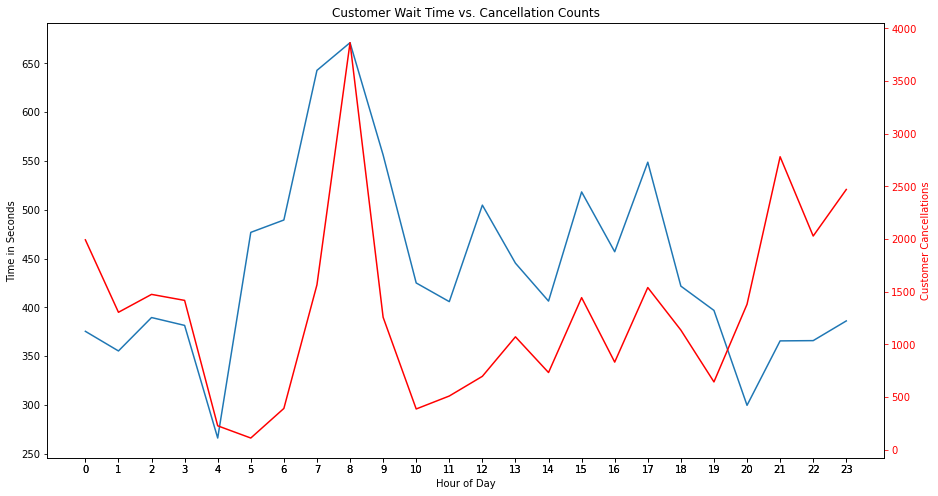

In [20]:
# creating a new figure with a size of 15 x 8 
fig, ax = plt.subplots(figsize = (15,8))

# creating a lineplot using seaborn and passing is_driver_assigned_hour as the data source with a focus on the average eta 
ax = sns.lineplot(data = eta_per_hour, x = 'hour', y = 'avg eta', ax = ax)

# renaming the title of the chart 
plt.title('Customer Wait Time vs. Cancellation Counts')

# renaming x axis to Hour of Day
plt.xlabel('Hour of Day')

# setting the tick marks to display all hours
plt.xticks(ticks = is_driver_assigned_hour['hour'])

# renaming the y axis to Cancellations Time in Seconds
plt.ylabel('Time in Seconds')

# setting up second y axis to plot cancellation counts
ax2 = ax.twinx()

# creating a lineplot using seaborn and passing is_driver_assigned_hour as the data source with a focus on the cancellation count
sns.lineplot(data = eta_per_hour, x = 'hour', y = 'cancellation count', color = 'red', ax = ax2)

# renaming the secondary y axis to Customer Cancellations
ax2.set_ylabel('Customer Cancellations')

# setting the colour of Title on the secondary axis to red
ax2.yaxis.label.set_color('red')

# editing the ticks on the secondary y axis, switching colour to red
ax2.tick_params(axis = 'y', colors = 'red')

# displaying the plot
plt.show();

### Key Takeaways

+ Adding the cancellation count was useful to visualize the relationship between these two variables
+ It is indicating that as the customer wait time increases, the customer cancellations rise as well
+ This is best demonstrated in the chart above when we look at 8 AM, customer wait times are a main driver as to why
+ The peaks in the afternoon are showing correlations between the two as well

### Next Steps

+ What can be done to reduce customer wait times - which will in turn reduce customer cancellations?
+ Are there specific areas where most of the volume is coming from?
+ Is there a need for a bigger driver pool? 
+ Or does it go beyond that, and is it a logistical issue? (Ie. Congested streets, traffic, etc)

## Bonus

### Using Geospatial Analysis Tools to calculate how many hexes contain 80% of cancellations

+ Use Uber's open source H3 and Folium libraries to build analysis
+ Build a table to sum the cumulative percentage of cancellations
+ This can be done by creating a count of the order_gk column, and then apply a cumulative percentage

### What is H3?

+ At its core, H3 is a geospatial analysis tool that provides a hexagonal, hierarchical spatial index to gain insights from large geospatial datasets 

### What is Folium?

+ Builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the leaflet.js library
+ folium makes it easy to visualize data that’s been manipulated in Python on an interactive leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map

### Mext Steps

+ Map latitude and longitude attributes that is available
+ An internal H3 ID will point to a specific hexagon
+ This will create a new column called hex_id
+ Build a table to create a count of the order_gk column grouped by hex_id, and then apply a cumulative percentage

### Important

+ In the geo_to_h3() function of the H3 library, the resolution parameter determines the level of the H3 grid system that is used to generate the hexagonal grid cell identifier
+ A higher resolution level (ie. resolution = 8) in the geo_to_h3() function will generate a hexagonal grid cell identifier that is smaller and more spatially precise than a lower resolution level (ie. resolution = 7)

In [21]:
import h3
import folium

# create a new column called 'hex_id' in df and fill it with hexagonal grid cell identifiers
# generated using the H3 library's 'geo_to_h3' function, applied to each row's 'origin_latitude' and 'origin_longitude' columns
df['hex_id'] = df.apply(func = lambda row: h3.geo_to_h3(lat = row['origin_latitude'], lng = row['origin_longitude'], resolution = 8), axis = 1)
df.sample(n = 10, random_state = 42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status,hour,hex_id
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,4,1,223.0,300050725946,Yes,Client Cancellation,21,88195d2b1dfffff
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,4,0,91.0,300052014519,No,Client Cancellation,10,88195d2845fffff
29083,9:16:38,-1.033560,51.441967,NaN,3000594099225,4,0,68.0,300051458740,No,Client Cancellation,9,88195d2947fffff
16926,2:08:09,-0.967676,51.444489,NaN,3000626980467,4,0,125.0,300052031394,No,Client Cancellation,2,88195d2b17fffff
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,4,0,11.0,300050671163,No,Client Cancellation,21,88195d2b1dfffff
13008,3:03:45,-0.966745,51.453236,NaN,3000593295623,9,0,NaN,300051413313,No,System Cancellation,3,88195d2b11fffff
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,4,0,6.0,300051090742,No,Client Cancellation,14,88195d2b1bfffff
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,9,0,NaN,300051125957,No,System Cancellation,20,88195d2b0dfffff
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,4,0,113.0,300052078801,No,Client Cancellation,18,88195d2b1bfffff
18189,7:52:29,-0.973793,51.458665,479.0,3000587781360,4,1,47.0,300051178628,Yes,Client Cancellation,7,88195d2b1dfffff


In [22]:
# creating a table grouped by hex_id and the cancellation count within that hexagon
hexes = df.groupby('hex_id')['order_gk'].count().reset_index().rename({"order_gk" : "cancellation count"}, axis = 1)

# understanding the length of the table
hexes

,hex_id,cancellation count
0,88195d2801fffff,65
1,88195d2803fffff,14
2,88195d2805fffff,10
3,88195d2807fffff,3
4,88195d2809fffff,46
...,...,...
134,88195d749dfffff,2
135,88195d74d1fffff,1
136,88195d74d3fffff,4
137,88195d74d5fffff,1


### Hexes Table Built

+ Sort the table by cancellation count ascending
+ Calculate the total sum of cancelled orders
+ Use the cumsum() function to get cumulutative sum to divide by total orders
+ Create a new column called cumulative percentage and find the closest data point to 80%

In [23]:
# sorting the hexes by cancellation count ascending
hexes = hexes.sort_values(by = 'cancellation count')

# calculating to sum of cancelled orders and storing it under the total_cancellations variable
total_cancellations = hexes['cancellation count'].sum()

# creating a new column calculating a cumulative sum using the cumsum function
hexes['cumulative sum'] = hexes['cancellation count'].cumsum()

# looking at the first ten rows of the dataset to ensure everything is working like it's supposed to
hexes.head(10)

,hex_id,cancellation count,cumulative sum
137,88195d74d5fffff,1,1
135,88195d74d1fffff,1,2
79,88195d2aebfffff,1,3
11,88195d282bfffff,1,4
122,88195d3993fffff,1,5
38,88195d2953fffff,1,6
30,88195d2901fffff,2,8
127,88195d39bbfffff,2,10
134,88195d749dfffff,2,12
126,88195d39b9fffff,3,15


In [24]:
# now that the cumulative sum is in place
# create a new column calculating a cumulative percentage to get to the closest data point to 80% or under
# rounding to the third decimal point after the percentage is multiplied by 100
hexes['cumulative perc'] = round(hexes['cumulative sum']/total_cancellations * 100,3)
hexes.tail(10)

,hex_id,cancellation count,cumulative sum,cumulative perc
88,88195d2b13fffff,975,12168,38.915
60,88195d2a25fffff,1074,13242,42.350
85,88195d2b0bfffff,1091,14333,45.839
61,88195d2a27fffff,1295,15628,49.981
20,88195d284dfffff,1937,17565,56.176
91,88195d2b19fffff,1960,19525,62.444
87,88195d2b11fffff,2191,21716,69.451
89,88195d2b15fffff,2461,24177,77.322
92,88195d2b1bfffff,2603,26780,85.647
93,88195d2b1dfffff,4488,31268,100.000


### Key Takeaways

+ Since the focus is look for the closest data point to 80% or under, 77% is the closest data point
+ Another interesting takeaway, the last two hexes contain 23% of all cancellations

### Next Steps

+ Filter data by cumulative percentage lower than or equal to 80%
+ Use folium to begin map creation

In [25]:
# creating the map using Folium
map = folium.Map(location=[df["origin_latitude"].mean(), df["origin_longitude"].mean()],
                 zoom_start=8.5,  # after a bit of experimentation, we thought this presents the map best
                 tiles="cartodbpositron")

In [26]:
import json
import geojson

# defining function to transform each row into a geojson object
def to_geojson(row):
    """Transform hex_id into a geojson object."""
    geometry = {
        "type": "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"], geo_json=True)]
    }
    # create a geojson feature object for the current row
    return geojson.Feature(id=row["hex_id"], geometry=geometry, properties={"cancellation count": row["cancellation count"]})

# listing comprehension to apply the function to each row to create a list of geojson objects
geojsons = [to_geojson(row) for _, row in hexes.iterrows()]

# use the json module to convert the list of geojson objects to a geojson FeatureCollection string
geojson_str = json.dumps(geojson.FeatureCollection(geojsons))

In [27]:
# instantiate a colormap object for better visualisation
colormap = plt.cm.get_cmap(name="plasma")

# storing the highest number of cancellations under max_cancellation
max_cancellation = hexes["cancellation count"].max()

# storing the lowest number of cancellations under min_cancellation
min_cancellation = hexes["cancellation count"].min()

### Important to Know

+ The fill_color of each hexagon is determined by the order of the hexagon, which is normalized between the minimum and maximum order values
+ The colormap function maps the normalized order value to a color value, which is then converted to a hex color string using to_hex()
+ Therefore, if a hexagon is darker in color, it means that its order value is higher relative to the other hexagons in the visualization

### In other words...

+ The darker hexagons are associated with higher values of the variable being visualized (cancellation count)
+ This can be useful for identifying patterns or hotspots in the data

In [28]:
import matplotlib

# defining a function to style hexagons and how to identify the hot spots for cancellations
def style_function(feature):
    # Compute the fill color for the feature
    fill_color = colormap((feature["properties"]["cancellation count"] - min_cancellation) / (max_cancellation - min_cancellation))
    return {
        "fillColor": matplotlib.colors.to_hex(fill_color),
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.3
    }

# create a geojson layer with the styled data
geojson_layer = folium.GeoJson(data=geojson_str, style_function=style_function)
geojson_layer.add_to(map)

In [29]:
map

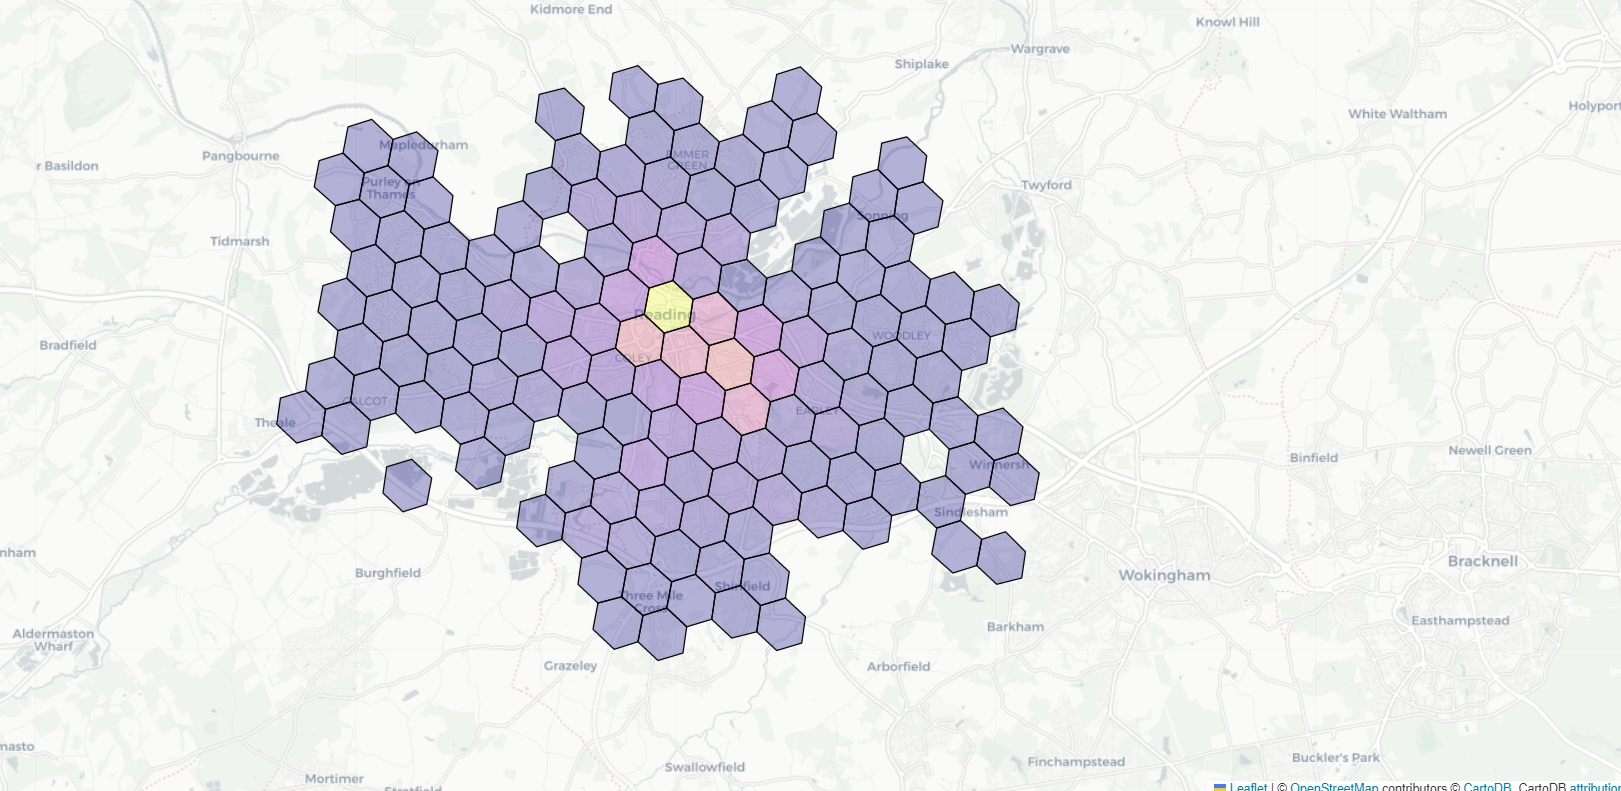

### Takeaways

+ Most of the darker circles (the hexagons with higher cancellation counts) are in the outskirts of Reading
+ This is important information to have, due to the fact that cancellations are directly correlated with customer wait times and driver ETA's
+ Areas closer to Reading and its centre, seem to be performing better from a customer cancellation perspective


### Recommendations

1. Understand the demand vs. current taxi pool in outskirts of Reading and its surroundings
2. Since we have better understanding of when they happen, and a big driver in customer wait times, the problem then becomes: What do we do about it?
3. Determine if the cost of bringing more drivers on board to have enough supply is greater than the cost of customer cancellations
4. Cancellations mean a forgettable customer experience, a potential lost customer to a competitor so there are important decisions to make

### Operational Recommendations

+ If the budgets make sense to bring on more driver to improve customer wait times and cancellations, there are a few operational opportunities to consider:
+ Understand the potential downsides of increasing driver supply and impact of focusing on the outskirts of the city from a driver experience / cost perspective

### Such as: 

+ Will it impact the amount of drivers they can complete in a day? (Likely) 
+ Will it impact their pay? (Also likely)
+ If this is likely, will the company have to come up with a compensation strategy to incentivize? (Could be the case)


### What else is needed?

+ Ensure the supply of drivers matches can withstand the customer volume
+ Distribution of drivers should be dispersed towards the outskirts of the city where the higher wait times and cancellation rates are higher